In [51]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, sampler
from torch import nn
import matplotlib.pyplot as plt
import numpy as np


In [52]:
def conv_2_block(in_dim,out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )
    return model

In [53]:
def conv_3_block(in_dim,out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )
    return model

In [54]:
class VGG(nn.Module):
    def __init__(self, base_dim, num_classes=10):
        super(VGG, self).__init__()
        self.feature = nn.Sequential(
            conv_2_block(3,base_dim), #64
            conv_2_block(base_dim,2*base_dim), #128
            conv_3_block(2*base_dim,4*base_dim), #256
            conv_3_block(4*base_dim,8*base_dim), #512
            conv_3_block(8*base_dim,8*base_dim), #512
        )
        self.fc_layer = nn.Sequential(
            # CIFAR10은 크기가 32x32이므로
            nn.Linear(8*base_dim*1*1, 4096),
            # IMAGENET이면 224x224이므로
            # nn.Linear(8*base_dim*7*7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 1000),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(1000, num_classes),
        )

    def forward(self, x):
        x = self.feature(x)
        #print(x.shape)
        x = x.view(x.size(0), -1)
        #print(x.shape)
        x = self.fc_layer(x)
        return x

In [55]:
batch_size = 100
learning_rate = 0.0002
num_epoch = 10

In [56]:
# device 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# VGG 클래스를 인스턴스화
model = VGG(base_dim=64).to(device)

# 손실함수 및 최적화함수 설정
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [58]:
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Transform 정의
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# CIFAR10 TRAIN 데이터 정의
cifar10_train = datasets.CIFAR10(root="cifar10", train=True, transform=transform, target_transform=None, download=True)

# CIFAR10 TEST 데이터 정의
cifar10_test = datasets.CIFAR10(root="cifar10", train=False, transform=transform, target_transform=None, download=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [59]:
train_loader = DataLoader(cifar10_train, batch_size=batch_size, sampler=sampler.SubsetRandomSampler(
    range(int(len(cifar10_train) * 0.98))))
val_loader = DataLoader(cifar10_train, batch_size=batch_size, sampler=sampler.SubsetRandomSampler(
    range(int(len(cifar10_train) * 0.98)), len(cifar10_train)))
test_loader = DataLoader(cifar10_test, batch_size=batch_size, shuffle=False)

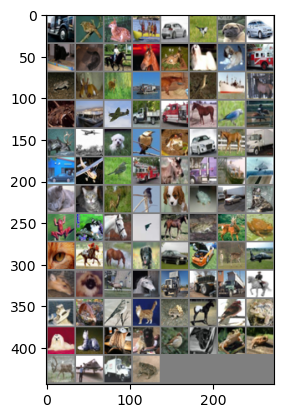

truck  bird  deer  ship   car  bird   dog   car   cat   cat horse horse  deer   dog   dog truck  frog  deer  deer  ship horse  bird  ship  deer  frog  ship plane truck truck horse  bird horse  deer plane   dog  bird  frog   car horse truck   car plane  bird truck  deer truck  ship plane   cat   cat  deer  bird   dog  frog   car   cat  frog   dog horse plane horse  frog  deer  frog   cat horse horse   dog   car   car  deer plane  deer   dog  deer horse truck truck truck horse  ship  deer  bird   cat  frog horse  bird  frog   dog   cat   cat   dog  bird   cat  frog  frog  deer plane truck  frog


In [60]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(train_loader)
images, labels = dataiter.next()

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))

# 정답(label) 출력
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

loss_arr = []
for i in range(num_epoch):
    for j,[image,label] in enumerate(train_loader):
        x = image.to(device)
        y_= label.to(device)

        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output,y_)
        loss.backward()
        optimizer.step()

    print(loss)
    loss_arr.append(loss.cpu().detach().numpy())

In [61]:
loss_arr = []
for i in range(num_epoch):
    for j,[image,label] in enumerate(train_loader):
        x = image.to(device)
        y_= label.to(device)

        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output,y_)
        loss.backward()
        optimizer.step()

        if (j + 1) % 30 == 0:
            print("Train Epoch:{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(i, j * len(image), len(train_loader.dataset), 100. * j / len(train_loader), loss.item()))

    print(loss)
    loss_arr.append(loss.cpu().detach().numpy())




Train Epoch:0 [2900/50000 (6%)]	Loss: 2.302358
Train Epoch:0 [5900/50000 (12%)]	Loss: 2.310840
Train Epoch:0 [8900/50000 (18%)]	Loss: 2.309439
Train Epoch:0 [11900/50000 (24%)]	Loss: 2.305167
Train Epoch:0 [14900/50000 (30%)]	Loss: 2.299767
Train Epoch:0 [17900/50000 (37%)]	Loss: 2.310595
Train Epoch:0 [20900/50000 (43%)]	Loss: 2.301138
Train Epoch:0 [23900/50000 (49%)]	Loss: 2.312323
Train Epoch:0 [26900/50000 (55%)]	Loss: 2.288456
Train Epoch:0 [29900/50000 (61%)]	Loss: 2.269740
Train Epoch:0 [32900/50000 (67%)]	Loss: 2.241358


KeyboardInterrupt: 

In [ ]:
plt.plot(loss_arr)
plt.show()